<b><h1>Books Recommendation System

In [2]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

<b><h3>Dataset

In [3]:
## Books
books = pd.read_csv("G:\ExcelR\Project\\Books.csv")
books.info()

## Ratings
ratings = pd.read_csv("G:\ExcelR\Project\\Ratings.csv")
ratings.info()

## Users
users = pd.read_csv("G:\ExcelR\Project\\Users.csv")
users.info()
#users = pd.read_csv(r"Datasets/Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
#ratings = pd.read_csv(r"Datasets/Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

#print("Books Data:    ", books.shape)
#print("Users Data:    ", users.shape)
#print("Books-ratings: ", ratings.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), obje

<b><h3>Pre-processing

<b>Books Dataset Pre-processing

In [4]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [6]:
## Checking for null values
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

In [7]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [8]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [9]:
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [10]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [13]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [14]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [15]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [16]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [17]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [18]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [19]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [20]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [21]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271046 non-null  object
 3   Year-Of-Publication  271047 non-null  int32 
 4   Publisher            271047 non-null  object
dtypes: int32(1), object(4)
memory usage: 9.3+ MB


In [22]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


<b>Users Dataset Pre-processing

In [23]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [24]:
## Checking null values
print(users.isna().sum())               

User-ID          0
Location         0
Age         110762
dtype: int64


In [25]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [26]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [27]:
mean = round(required['Age'].mean())   
mean

35

In [28]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [29]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [30]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


In [32]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


<b>Books-Ratings Dataset Pre-processing

In [33]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [34]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [35]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [36]:
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [37]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [38]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [39]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [40]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [41]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [42]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<h3><b>Merging of all three Tables

<b>Merging Books, Users and Rating Tables in One

In [43]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031608 non-null  object
 3   Year-Of-Publication  1031609 non-null  int32 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int32 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int32(2), int64(2), object(7)
memory usage: 78.7+ MB


<b>Divide complete data on the basis of Implicit and Explicit ratings datasets

In [44]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [45]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [46]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


<h3><b>Data Visualization

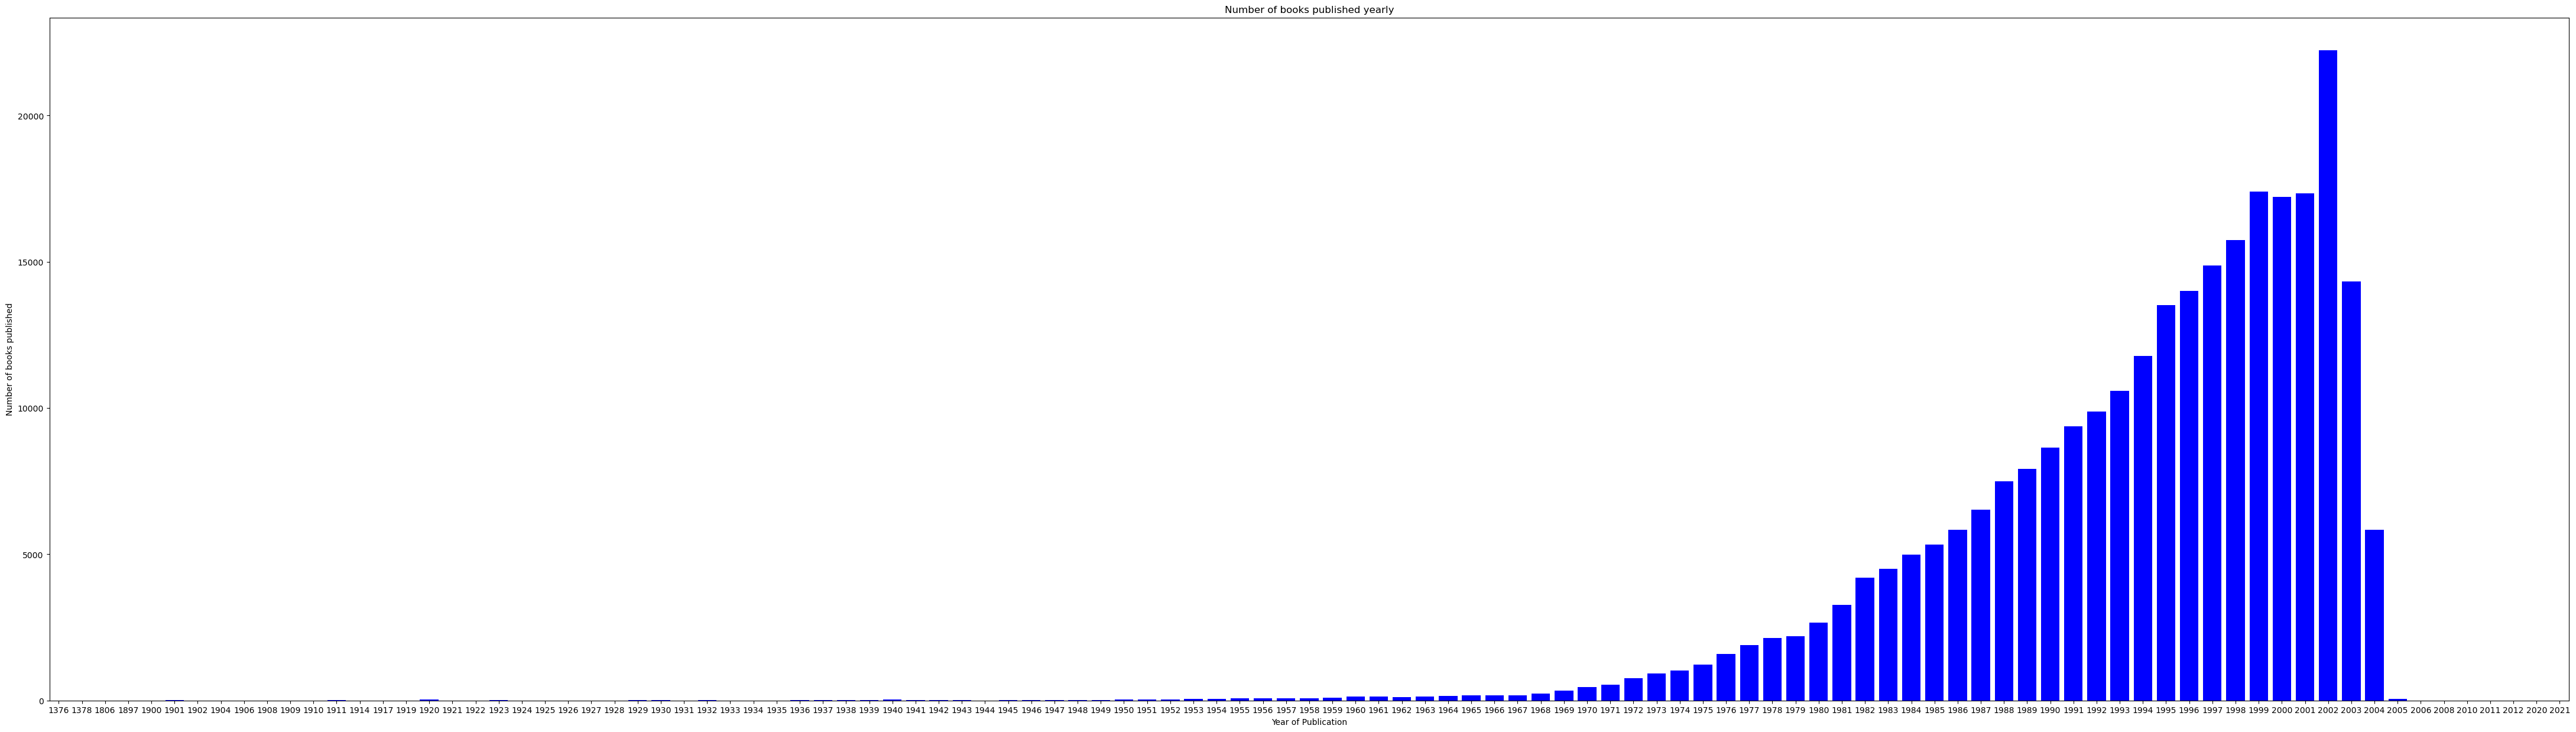

In [47]:
# bar graph - Number of books published yearly
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

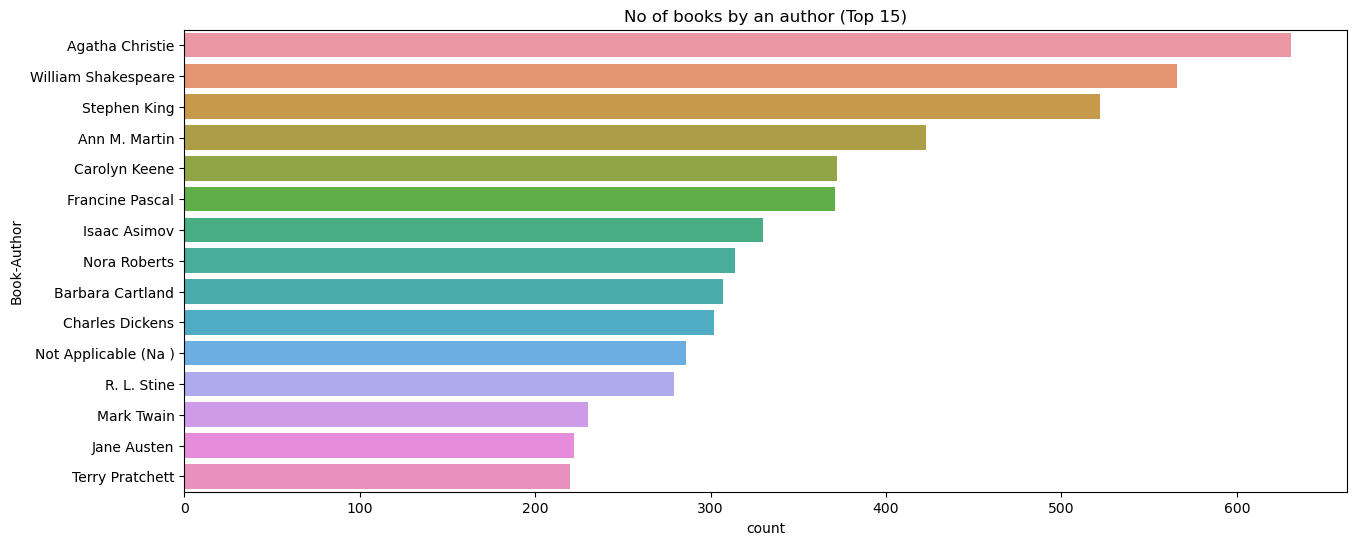

In [48]:
#CountPlot, No of books by an author (Top 15)
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

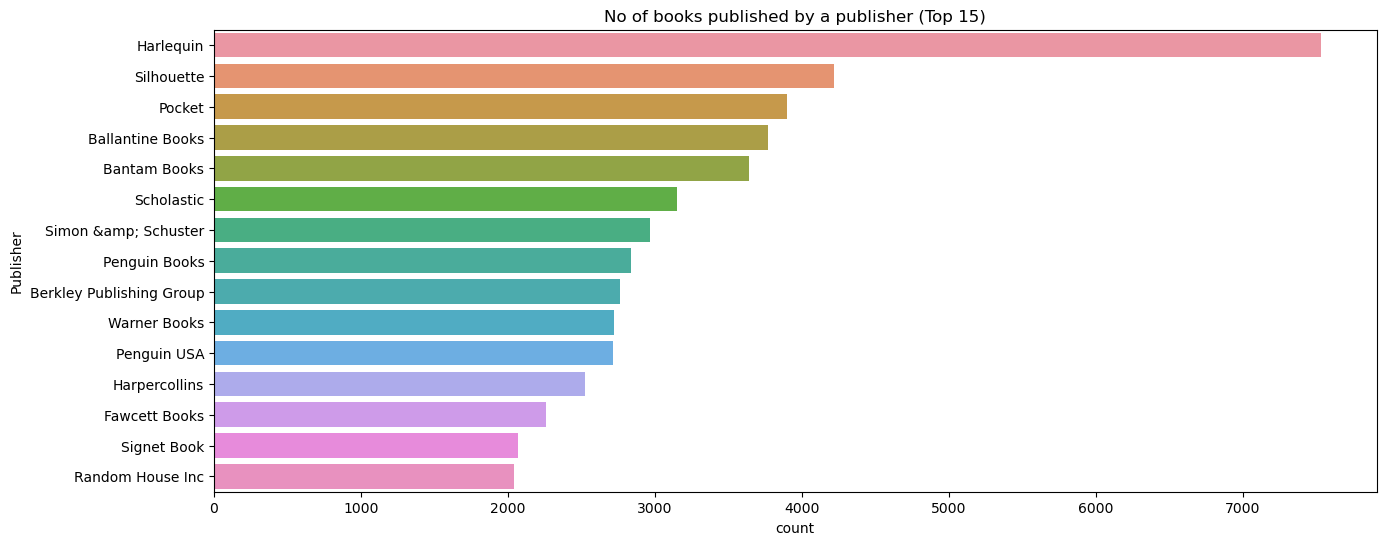

In [49]:
#CountPlot, No of books by an Publisher (Top 15)
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

<Axes: xlabel='Book-Rating', ylabel='count'>

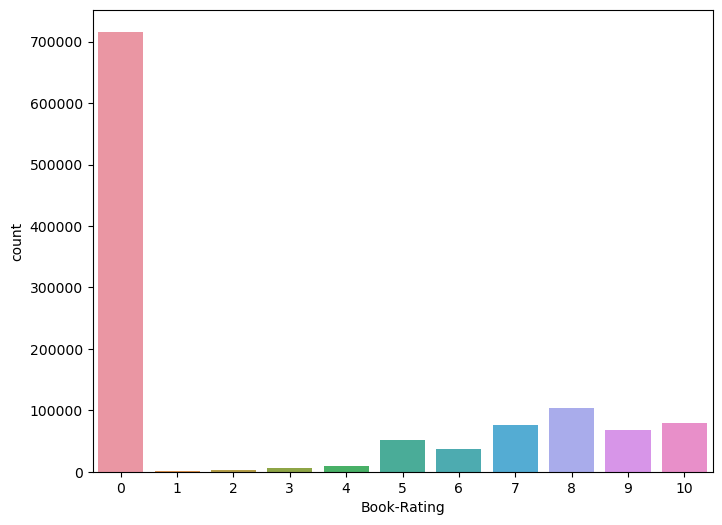

In [50]:
# countplot on Book Rating
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

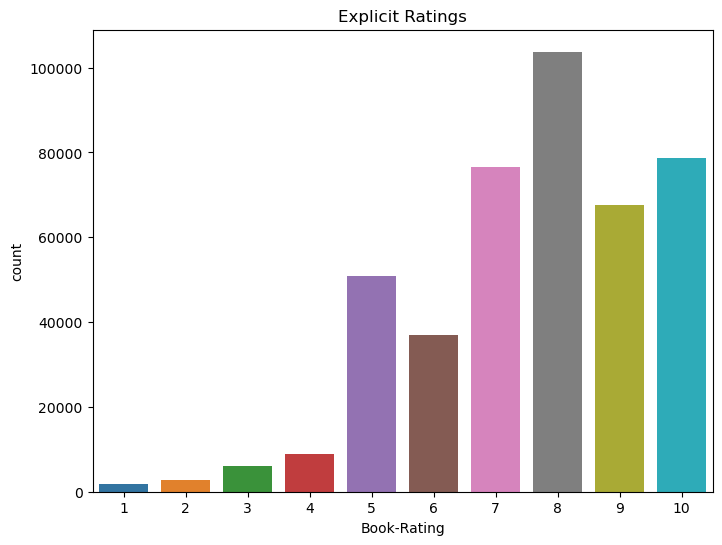

In [51]:
## Explicit Ratings - book rating and there count
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

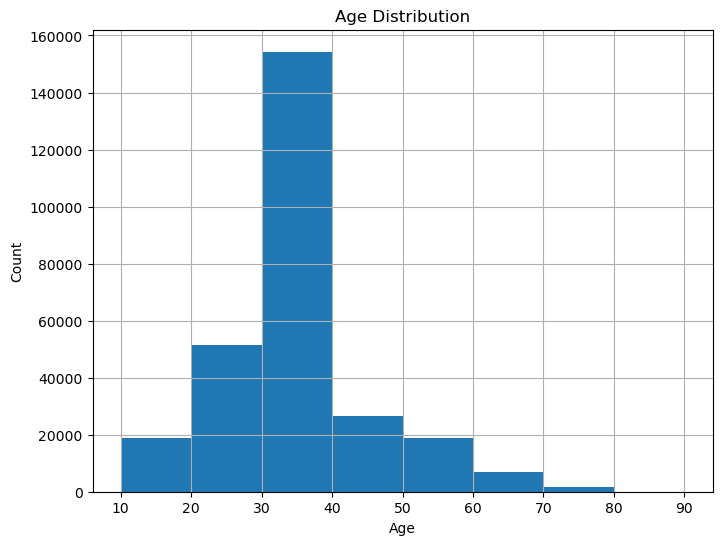

In [52]:
#Bar raph on Age disturbtion abd tere cunt
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

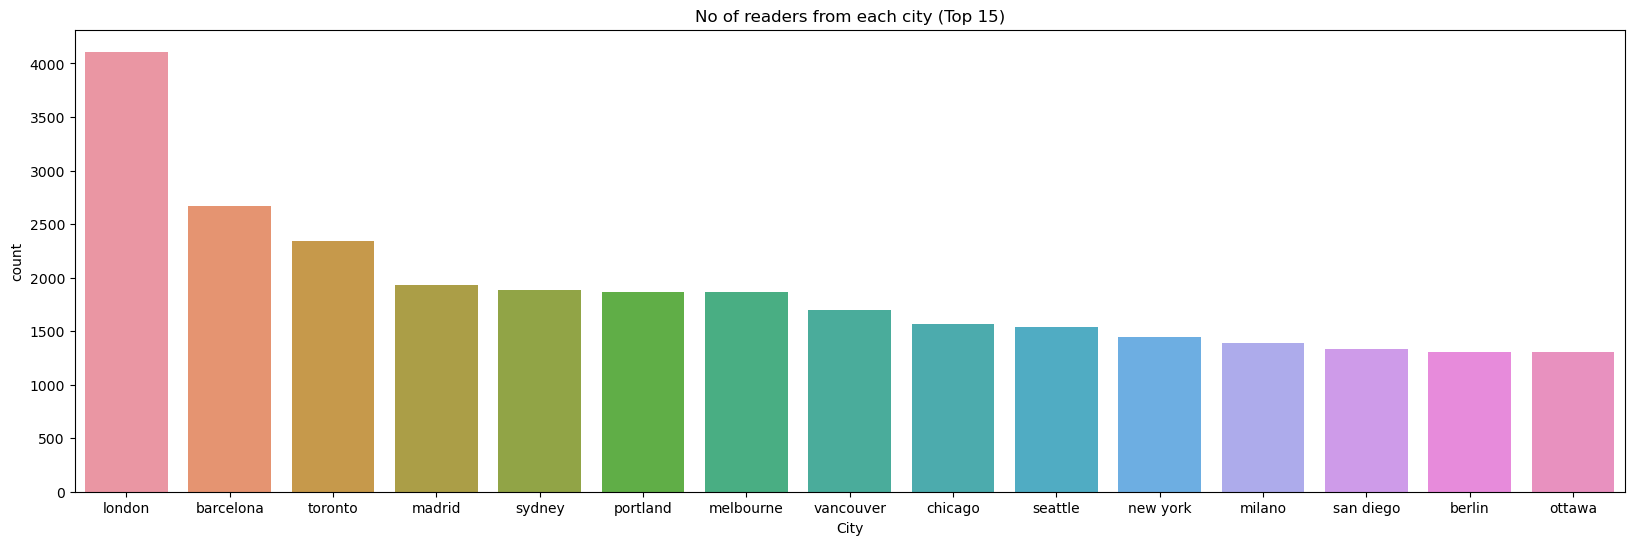

In [53]:
# Countplot - No of readers from each city (Top 15)
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

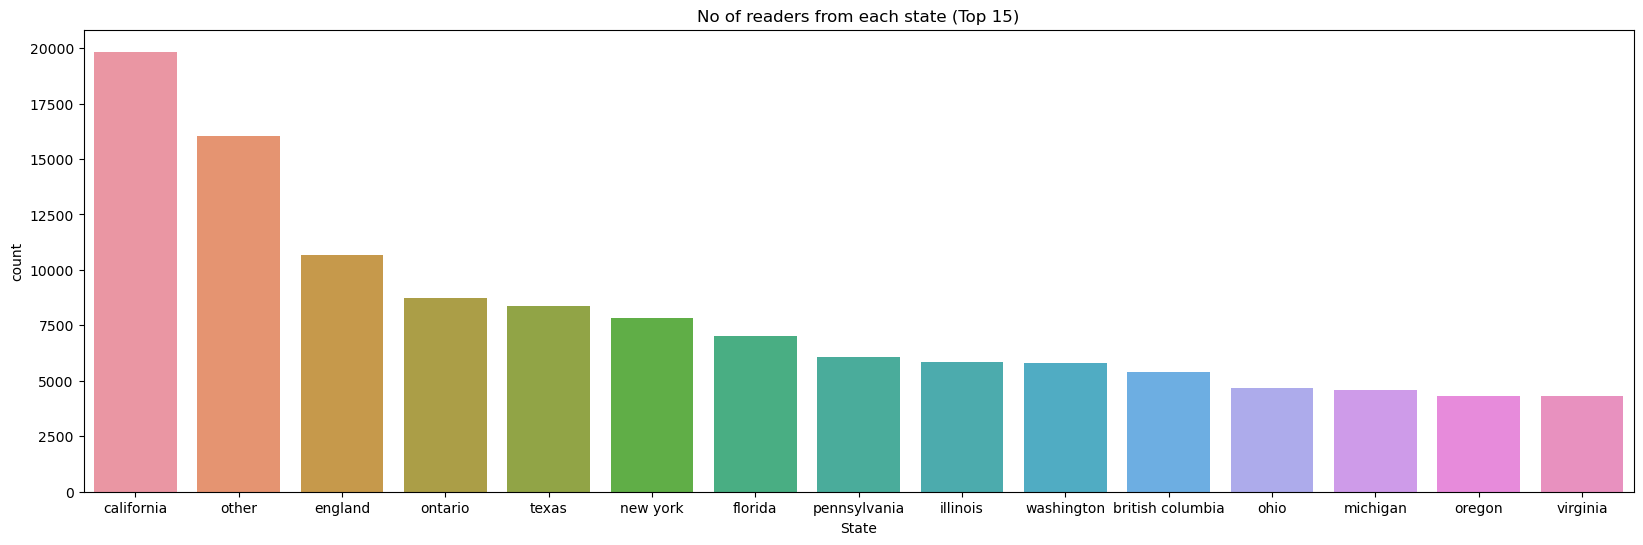

In [54]:
# No of readers from each State (Top 15)
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

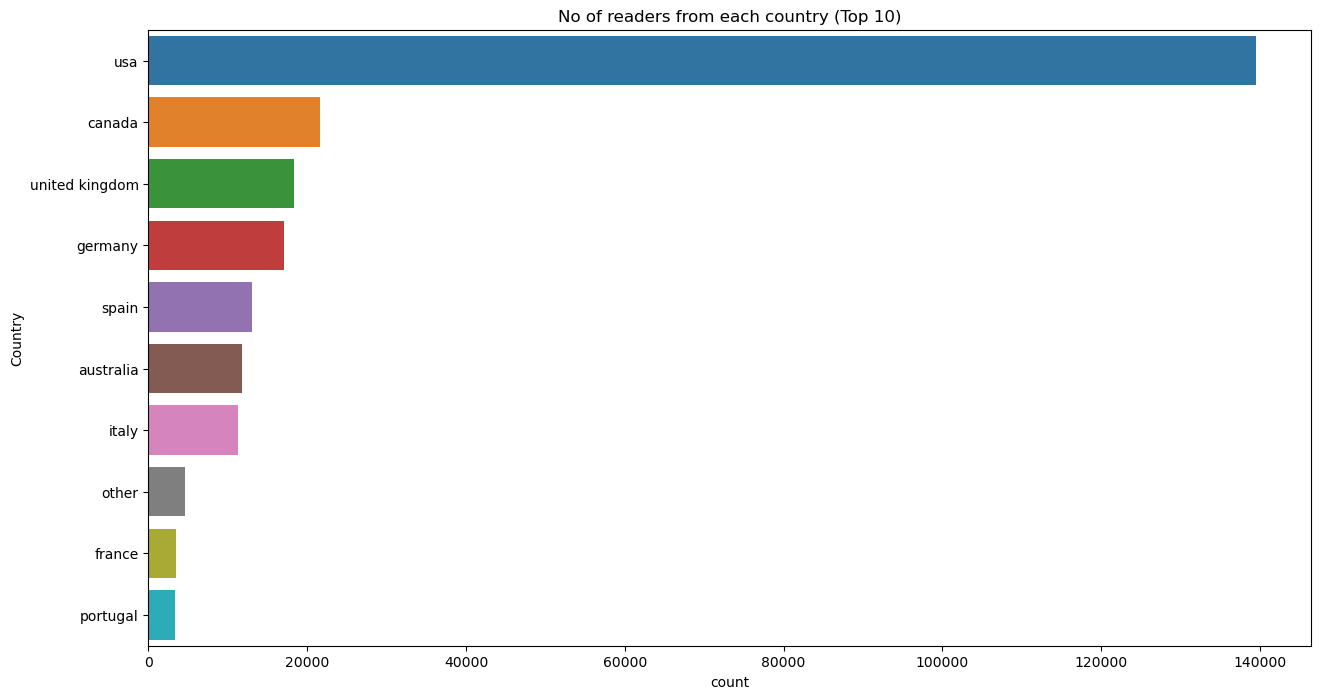

In [55]:
# No of readers from each Country (Top 15
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

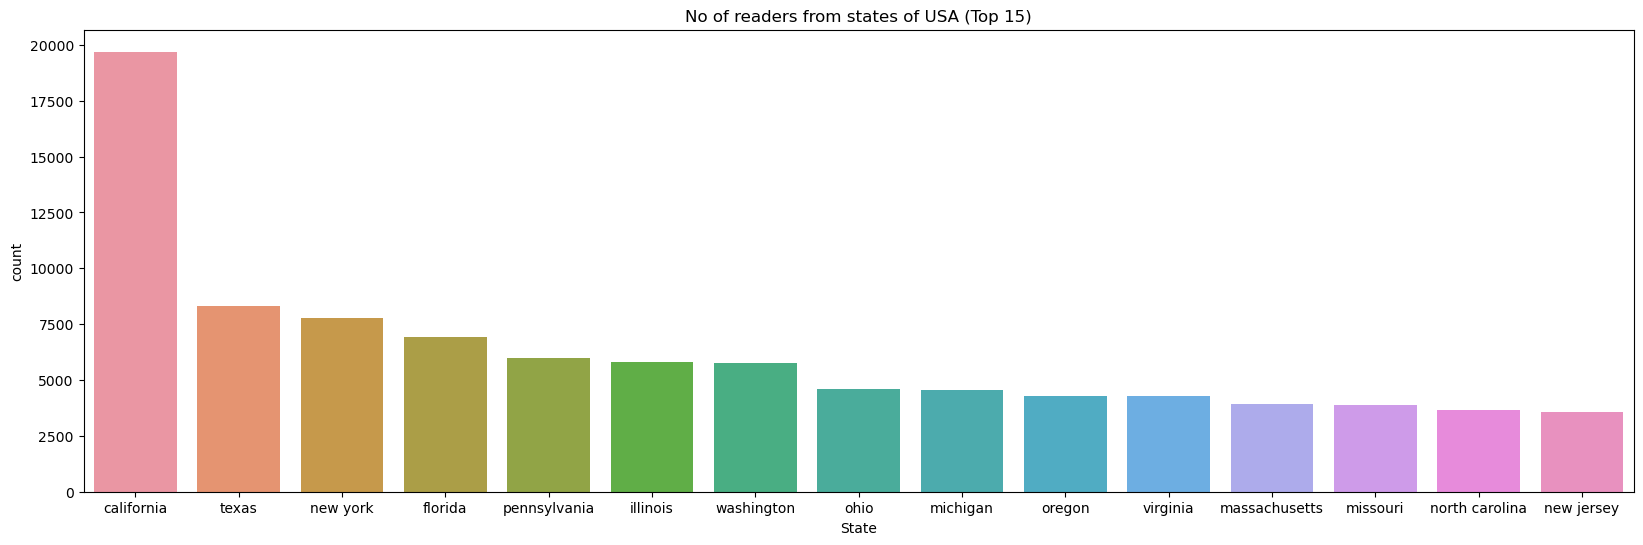

In [56]:
# No of readers from states of USA (Top 15) based in USA states
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

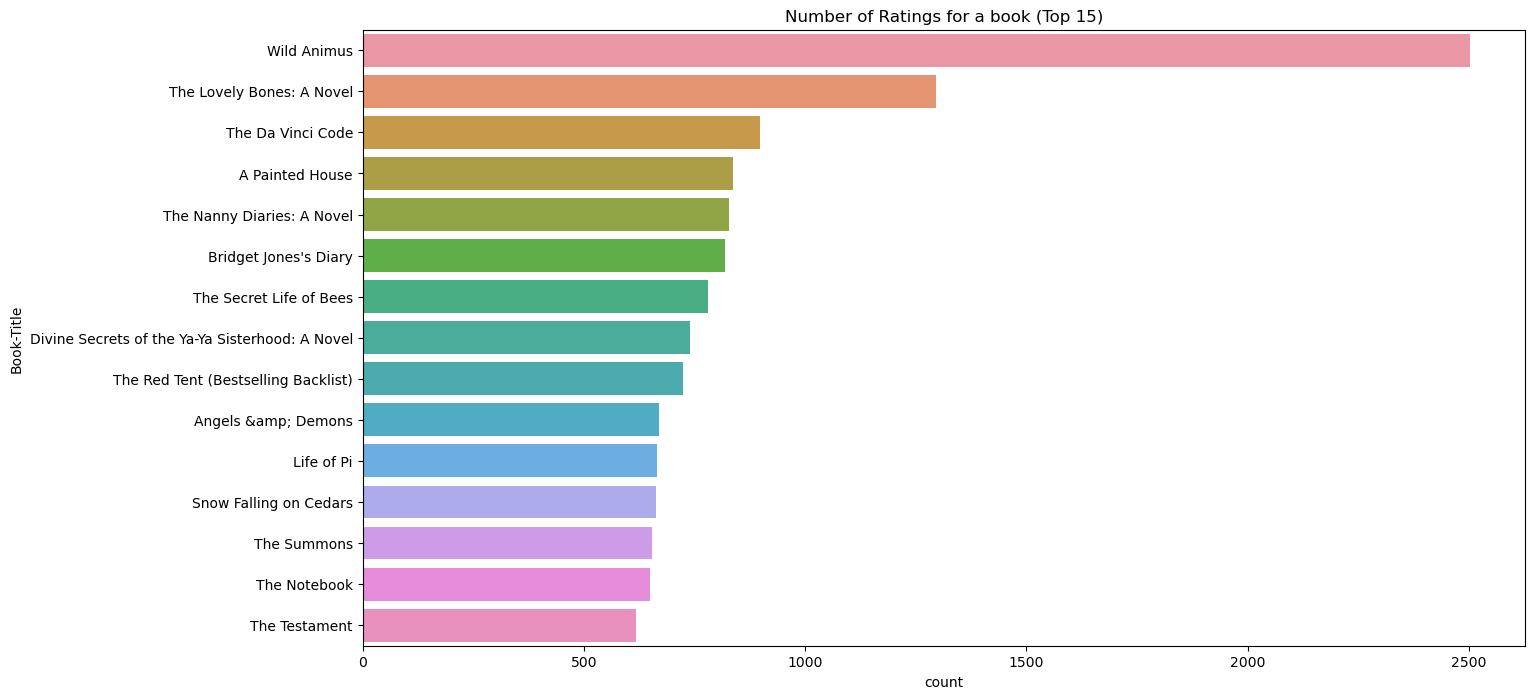

In [57]:
# Number of Ratings for a book (Top 15) on Book Title
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

<h2><b>Recommendation Systems

In [58]:
# here we are trying to enter Book name along with Books to be recommend.
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Example Book: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
# Example Book: More Cunning Than Man: A Social History of Rats and Man

Enter a book name:  More Cunning Than Man: A Social History of Rats and Man
Enter number of books to recommend:  10


<h5><b> 1. Popularity Based (Top In whole collection)

In [59]:
# here we are trying to print the Top Popular books that we entered to recommend in the above. It also returns if any invalid no of books are entered.
def popularity_based(dataframe, books, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        data.reset_index(inplace=True)  # Ensure 'ISBN' is a column and not an index
        result = pd.merge(data, books, on='ISBN') # it will merge books on ISBN
        return result
    return "Invalid number of books entered!!"

In [60]:
result = popularity_based(dataset1, books, number)
print("Top", number, "Popular books are: ")
#print(result)
result.head()

Top 10 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


<h5><b>2. Popularity Based (Top In a given place)

In [61]:
# Here we will give the city, state or country name to get the book details. It also shows invalid Entry if entered wrong.
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [62]:
# Displays the list of recommended books from the given Place. Ex: India, Mumbai, USA etc...;
# Prompt the user to enter the name of a place
place = input("Enter the name of place: ")
# Search for unique places in dataset1 based on the user's input
data = search_unique_places(dataset1, place)
# If the result is a DataFrame, apply a popularity-based filter using books and number
if isinstance(data, pd.DataFrame):
    data = popularity_based(data, books, number)
# Display the resulting data
data

#Example: India, Mumbai, darwin, australia 

Enter the name of place:  India


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0971880107,3,Wild Animus,Rich Shapero,2004,Too Far
1,0671047612,2,Skin And Bones,Franklin W. Dixon,2000,Aladdin
2,0486284735,2,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995,Dover Publications
3,8171670407,2,Inscrutable Americans,Mathur Anurag,1996,South Asia Books
4,0006944035,1,Secret Island / Secret Mountain (Two-in-ones),Enid Blyton,1994,HarperCollins Publishers
5,067189109X,1,The Blessing,Jude Deveraux,1999,Pocket Star
6,0671711172,1,Seven Habits of Highly Effective People,Stephen R. Covey,1992,Simon &amp; Schuster (Trade Division)
7,0671679414,1,Memoirs of a Mangy Lover,Groucho Marx,1989,Simon &amp; Schuster
8,0671657518,1,HT STOP WORRYING R,Dale Carnegie,1987,Pocket
9,0671505173,1,CROSS COUNTRY CRIME (HARDY BOYS 134) : CROSS COUNTRY CRIME (Hardy Boys),Franklin W. Dixon,1995,Aladdin


<b><h5>3. Books by same author, publisher of given book name

In [63]:
def printBook(k, n):
    # Get unique book titles from the 'Book-Title' column in the DataFrame k
    z = k['Book-Title'].unique()
    # Loop through the unique book titles and print each one
    for x in range(len(z)):
        print(z[x])
        # Stop printing after n titles have been printed
        if x >= n-1:
            break

In [64]:
def get_books(dataframe, name, n):
    # Print books by the same author and publisher excluding the given book.
    print("\nBooks by same Author:\n")
    # Get unique authors from the dataframe.
    au = dataframe['Book-Author'].unique()

    # Exclude the given book title from the dataset.
    data = dataset1[dataset1['Book-Title'] != name]

    # Check if the first unique author is in the filtered data.
    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    # Sort the filtered data by book rating and print the top n books.
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    
    # Get unique publishers from the dataframe
    au = dataframe['Publisher'].unique()

    # Check if the first unique publisher is in the filtered data.
    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    # Sort the filtered data by book rating and print the top n books.
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [65]:
# Check if the specified bookName is in the unique list of 'Book-Title' from dataset1
if bookName in list(dataset1['Book-Title'].unique()):
    # If it is, filter dataset1 to include only rows where 'Book-Title' matches bookName,
    d = dataset1[dataset1['Book-Title'] == bookName]
    # and call get_books() with the filtered dataset, bookName, and number.
    get_books(d, bookName, number)
else:
    # If bookName is not found, print an error message indicating an invalid book name.
    print("Invalid Book Name!!")


Books by same Author:

New Yawk Tawk: A Dictionary of New York City Expressions
American Talk: The Words and Ways of American Dialects
The Facts on File Encyclopedia of Word and Phrase Origins (Facts on File)


Books by same Publisher:

The Special Guest: A Christmas Story
A Thirst for Rain
Yesterday
What You Wish for
Sweet River (Precious Gem Historical Romance, #50)
My Rebellious Bride
The Lover
Celebration
Hair Raiser: A Bad Hair Day Mystery (Bad Hair Day Mysteries (Paperback))
Face Down in the Marrow-Bone Pie


<h5><b>4. Books popular Yearly

In [66]:
# Grouping and sorting the dataset
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)

# Resetting index to make 'ISBN' a column
data.reset_index(inplace=True)

# Merging data with books DataFrame
data = pd.merge(data, books, on='ISBN')

# Filtering by unique years of publication
years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

# Dropping duplicate years and the 'Book-Rating' column
data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

# Setting display options
pd.set_option("display.max_rows", None, "display.max_columns", None)
data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
73895,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz
73896,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
130309,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81469,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125519,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside


<b><h5>5. Average Weighted Ratings

In [67]:
# Compute the total ratings count
df = dataset1['Book-Title'].value_counts().reset_index()
df.columns = ['Book-Title', 'Total-Ratings']

# Compute the average rating for each book title
avg_ratings = dataset1.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_ratings.columns = ['Book-Title', 'Average Rating']

# Merge total ratings and average ratings
df = pd.merge(df, avg_ratings, on='Book-Title')

# Save to pickle file
df.to_pickle('weightedData')

# Read from pickle file
df = pd.read_pickle('weightedData')

# Display the final DataFrame
print(df)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [68]:
## C - Mean vote across the whole
C = df['Average Rating'].mean()

## Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [69]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [70]:
# Filter the DataFrame to include only rows where 'Total-Ratings' is greater than or equal to 'm'.
df = df.loc[df['Total-Ratings'] >= m]

# Calculate the 'score' for each row using the 'weighted_rating' function.
df['score'] = df.apply(weighted_rating, axis=1)

# Sort the DataFrame by the 'score' column in descending order.
df = df.sort_values('score', ascending=False)

# Print the top 'number' of recommended books.
print("Recommended Books:-\n")
df.head(number)

Recommended Books:-



,Book-Title,Total-Ratings,Average Rating,score
1877,Harry Potter and the Chamber of Secrets Postcard Book,23,9.869565,9.450512
111,"The Two Towers (The Lord of the Rings, Part 2)",136,9.330882,9.266768
3852,Dilbert: A Book of Postcards,13,9.923077,9.256352
1802,Calvin and Hobbes,24,9.583333,9.228080
4587,Postmarked Yesteryear: 30 Rare Holiday Postcards,11,10.000000,9.225896
2255,The Authoritative Calvin and Hobbes (Calvin and Hobbes),20,9.600000,9.184573
1971,"My Sister's Keeper : A Novel (Picoult, Jodi)",22,9.545455,9.170901
178,"The Return of the King (The Lord of the Rings, Part 3)",103,9.213592,9.135318
3012,"The Return of the King (The Lord of The Rings, Part 3)",16,9.625000,9.124492
1580,The Giving Tree,26,9.423077,9.116591


# Collaborative Filtering (User-Item Filtering) : Is a technique used to predict user preferences based on the behavior of similar users.

In [71]:
# Check if 'Book-Title' column exists
if 'Book-Title' in dataset1.columns:
    # Compute the total ratings count
    book_title_counts = dataset1['Book-Title'].value_counts().reset_index()
    book_title_counts.columns = ['Book-Title', 'Total-Ratings']

    # Merge total ratings with the original dataset
    df = pd.merge(dataset1, book_title_counts, on='Book-Title', how='left')

    # Drop unnecessary columns
    df = df.drop(['Year-Of-Publication', 'Publisher', 'Age', 'City', 'State', 'Country'], axis=1)

    # Apply popularity threshold
    popularity_threshold = 50
    popular_books = df[df['Total-Ratings'] >= popularity_threshold].reset_index(drop=True)

    print(popular_books)
else:
    print("The column 'Book-Title' does not exist in the dataset.")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [72]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, accuracy_score, mean_squared_error
import numpy as np

# Assuming we have additional data like predicted ratings or classifications

np.random.seed(42)
ratings_true = np.random.randint(1, 6, size=len(popular_books))  # Example true ratings (1 to 5)
ratings_predicted = np.random.randint(1, 6, size=len(popular_books))  # Example predicted ratings (1 to 5)

# Example true and predicted classifications (for precision, accuracy)
true_classes = np.random.randint(0, 2, size=len(popular_books))  # Binary classes (0 or 1)
predicted_classes = np.random.randint(0, 2, size=len(popular_books))  # Example predicted classes (0 or 1)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ratings_true, ratings_predicted))

# Compute F1 score, Precision score, and Accuracy score
f1 = f1_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print evaluation metrics
print("RMSE Score:", rmse.round(4))
print("F1 Score:", f1.round(4))
print("Precision Score:", precision.round(4))
print("Accuracy Score:", accuracy.round(4))


RMSE Score: 2.0055
F1 Score: 0.501
Precision Score: 0.5019
Accuracy Score: 0.4989


# User-Based Collaborative Filtering: Is used to predict the items that a user might like on the basis of ratings given to that item by other users who have similar taste with that of the target user.

In [73]:
# Creating a new DataFrame 'testdf' with columns 'ISBN', 'Book-Rating', and 'User-ID' from 'popular_books' DataFrame.
testdf = pd.DataFrame()
testdf['ISBN'] = popular_books['ISBN']
testdf['Book-Rating'] = popular_books['Book-Rating']
testdf['User-ID'] = popular_books['User-ID']

# Then, grouping 'testdf' by the 'ISBN' column and keeping only 'User-ID' and 'Book-Rating' columns.
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [74]:
# Initialize empty list and dictionaries for indexing and reverse indexing
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

# Iterate over each group in the DataFrame
for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    # Populate a temporary dictionary with key-value pairs from the group DataFrame
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
     # Map the current index to the group key and vice versa
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    # Add the temporary dictionary to the list
    listOfDictonaries.append(tempDict)
    
# Convert the list of dictionaries to a sparse matrix
dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)

# Compute pairwise cosine similarity between the vectors
pairwiseSimilarity = cosine_similarity(vector)

In [75]:
# Functions to print book details and get top recommendations based on collaborative filtering
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    
    # Print input book details
    print("Input Book:")
    printBookDetails(bookID)

    # Print recommendations
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    # Iterate through sorted similarity scores
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [126]:
# Here we enter the Book Name, It will recommened based on your choice.
bookName = str(input("Enter the book name you want"))  # Replace with the actual book name you want to search for

#bookName = "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
# List of book titles and ISBNs
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

# Check if the bookName exists in the list k
if bookName in k:
    isbn = m[k.index(bookName)]
    # Assuming getTopRecommandations is a defined function that takes an ISBN
    collaborative = getTopRecommandations(isbn)
    print(collaborative)
else:
    print(f"The book '{bookName}' does not exist in the dataset.")

## Input 1 Book: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
## Input 2 Book: The Two Towers (The Lord of the Rings, Part 2)

Enter the book name you want Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))


Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe
The Two Towers (The Lord of the Rings, Part 2)
Cold Sassy Tree
The Secret Garden
Anne of Green Gables (Anne of Green Gables Novels (Paperback))
Like Water for Chocolate: A Novel in Monthly Installments With Recipes, Romances and Home Remedies
['Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', 'Harry Potter and the Order of the Phoenix (Book 5)', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Fried Green Tomatoes at the Whistle Stop Cafe', 'The Two Towers (The Lord of the Rings, Part 2)', 'Cold Sassy Tree', 'The Secret Garden', 'Anne of Green Gables (Anne of Green Gables Novels (Paperback))', 'Like W

# Correlation method : Is used for finding the association between the features for sample data.

In [78]:
# Filter the dataset to include only users and book ratings that appear at least 'popularity_threshold' times.
popularity_threshold = 50

# 1. Calculate the count of ratings per user
user_count = dataset1['User-ID'].value_counts()
# 2. Filter out users with fewer ratings than the threshold
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
# 3. Calculate the count of each book rating.
rat_count = data['Book-Rating'].value_counts()
# 4. Filter out ratings that appear less frequently than the threshold.
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

# 5. Create a pivot table with 'User-ID' as rows, 'ISBN' as columns, and 'Book-Rating' as values, filling missing values with 0.
matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [79]:
# Group dataset1 by 'ISBN' and calculate the mean 'Book-Rating' for each ISBN. Store this in a DataFrame called average_rating.
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())

# Add a new column 'ratingCount' to average_rating, which contains the count of 'Book-Rating' for each ISBN from the ratings DataFrame.
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())

# Sort average_rating by 'ratingCount' in descending order and display the top rows.
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


# Hybrid Models/Approach : Combines (Content + Collaborative) filterings and Integrates multiple models (e.g., CF, CBF, demographic filtering)

In [124]:
# Initialize an empty list
z = list()

# Calculate k as a float value derived from 1 divided by 'number'
k = float(1/number)

# Populate list 'z' with values based on the formula 1 - k * x for each x in range(number)
for x in range(number):
      z.append(1-k*x)
# Initialize an empty dictionary 'dictISBN'
dictISBN = {}

# Populate 'dictISBN' based on values from list 'z' using elements from 'collaborative'
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

# Check elements from 'content' and update 'dictISBN' accordingly
for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

# Sort 'dictISBN' based on values in descending order and store the result in 'ISBN'
ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))

# Initialize 'w' as 0 and print the input book name
w=0
print("Input Book:\n")
print(bookName)

# Print recommended books from 'ISBN' until 'number' of recommendations are reached
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
The Street Lawyer
Harry Potter and the Goblet of Fire (Book 4)
Jack &amp; Jill (Alex Cross Novels)
Harry Potter and the Order of the Phoenix (Book 5)
The Five People You Meet in Heaven
Fried Green Tomatoes at the Whistle Stop Cafe
Guilty Pleasures (Anita Blake Vampire Hunter (Paperback))
The Two Towers (The Lord of the Rings, Part 2)


# Evalution of Metrics (F1 Score, Precision Score, Accuracy Score and RMSE values)

In [125]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, mean_squared_error

# Assuming we have additional data like predicted ratings or classifications
np.random.seed(45)
ratings_true = np.random.randint(1, 6, size=len(popular_books))  # Example true ratings (1 to 5)
ratings_predicted = np.random.randint(1, 6, size=len(popular_books))  # Example predicted ratings (1 to 5)

# Example true and predicted classifications (for precision, accuracy)
true_classes = np.random.randint(0, 2, size=len(popular_books))  # Binary classes (0 or 1)
predicted_classes = np.random.randint(0, 2, size=len(popular_books))  # Example predicted classes (0 or 1)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ratings_true, ratings_predicted))

# Compute F1 score, Precision score, and Accuracy score
f1 = f1_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
accuracy = accuracy_score(true_classes, predicted_classes)

# Print evaluation metrics
print("RMSE Score:", rmse.round(4))
print("F1 Score:", f1.round(4))
print("Precision Score:", precision.round(4))
print("Accuracy Score:", accuracy.round(4))


RMSE Score: 2.0029
F1 Score: 0.4984
Precision Score: 0.4992
Accuracy Score: 0.4999


# Nerest Neighborhood Selection: A nearest neighbor algorithm plots all vectors in a multi-dimensional space and uses each of the points to find a neighboring point that is nearest.

# User-Based: Identify the nearest neighbors (users) who has similar tastes or preferences.
# Item-Based: Finds items that are most similar to a given item based on user interactions.

In [87]:
# Group dataset1 by 'Book-Title', count ratings, rename columns, and select relevant columns
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

# Merge aggregated data back with dataset1
result = pd.merge(data, dataset1, on='Book-Title')

# Filter books with ratings count above 'popularity_threshold' and reset index
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

# Create a user-book rating matrix with Book-Title as index, User-ID as columns, fill NaN with 0
matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)

# Convert the matrix to Compressed Sparse Row format for efficient storage and computation
up_matrix = csr_matrix(matrix)

In [82]:
# Initialize a NearestNeighbors model using cosine distance and brute-force algorithm
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

# Fit the model with the `up_matrix` data
model.fit(up_matrix)

# Find the nearest neighbors (recommended books) for a given book (`bookName`)
# based on its features (values in `matrix`)
distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)

# Print recommended books excluding the input book itself
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

The Return of the King (The Lord of the Rings, Part 3)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Hobbit : The Enchanting Prelude to The Lord of the Rings
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Charlotte's Web (Trophy Newbery)
Stranger in a Strange Land (Remembering Tomorrow)
The Silmarillion


Model Deployement 

In [ ]:
import pickle
import os

os.makedirs("artifacts",exist_ok=True)
pickle.dump(model , open('artifacts/model.pkl','wb'))
pickle.dump(books_name, open('artifacts/books_name.pkl','wb'))
pickle.dump(df,open('artifacts/final_rating.pkl','wb'))
pickle.dump(book_pivot,open('artifacts/book_pivot.pkl','wb'))

In [ ]:
def recommend_book(book_name):
    book_id = np.where(book_pivot.index == book_name)[0][0]
    distance , suggestion = model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1),n_neighbors=9)
    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        for j in books:
            print(j)

In [96]:
np.where(book_pivot.index == "Harry Potter and the Goblet of Fire (Book 4)")[0][0]

473


In [117]:
book_name = "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
recommend_book(book_name)

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe
The Two Towers (The Lord of the Rings, Part 2)
Cold Sassy Tree
The Secret Garden
Anne of Green Gables (Anne of Green Gables Novels (Paperback))
Like Water for Chocolate: A Novel in Monthly Installments With Recipes, Romances and Home Remedies
['Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', 'Harry Potter and the Order of the Phoenix (Book 5)', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Fried Green Tomatoes at the Whistle Stop Cafe', 'The Two Towers (The Lord of the Rings, Part 2)', 'Cold Sassy Tree', 'The Secret Garden', 'Anne of Green Gables (Anne of Green Gables Novels (Paperback))', 'Like W